<a href="https://colab.research.google.com/github/a1coderxt/a1coderxt/blob/main/03_Computer_Vision_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch Computer Vision

### 0. Computer Vision Libraries in PyTorch

* `torchvision` - base domain library for PyTprch computer vision
* `torchvision.dataset` - get dataset and data loading functions for computer vision
* `torchvision.models` - get pretrained computer vision model that you can leverage for your own problems
* `torchvision.transforms` - fumction for manipulating your vision data (images) to be suitable for use with an ML model
* `torch.utils.data.Dataset` - Base dataset class for PyTorch.
* `torch.utils.DataLoader` - Creates a Python iterable over a dataset

In [1]:
# imports
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a dataset

The dataset we'll be using is FASHIONMNIST Database

In [2]:
import os
from google.colab import drive

drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/fashion_mnist_data"

# Only download if files not found
if not os.path.exists(os.path.join(dataset_path, 'FashionMNIST')):
    print("Dataset not found — downloading...")
    download_flag = True
else:
    print("Dataset found — skipping download.")
    download_flag = False

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

train_data = datasets.FashionMNIST(
    root=dataset_path,
    train=True,
    download=download_flag,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root=dataset_path,
    train=False,
    download=download_flag,
    transform=ToTensor()
)


Mounted at /content/drive
Dataset found — skipping download.


In [3]:
len(train_data) , len(test_data)

(60000, 10000)

In [5]:
class_name = train_data.classes
class_name

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### 1.1 Checking the Input and output shapes of data

In [7]:
# Check the shape of image
print(f"Image Shape: {image.shape}")
print(f"Image label: {class_name[label]}")

Image Shape: torch.Size([1, 28, 28])
Image label: Ankle boot


### 1.2 Visualize our data

Image Shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

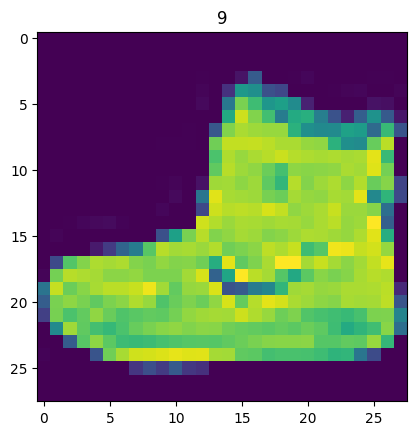

In [8]:
import matplotlib.pyplot as plt
image , label = train_data[0]
print(f"Image Shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label)
# image

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

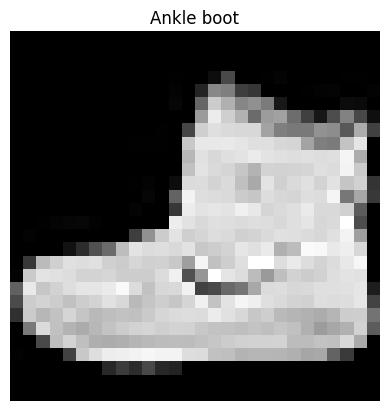

In [9]:
plt.imshow(image.squeeze() , cmap="gray")
plt.title(class_name[label])
plt.axis(False)

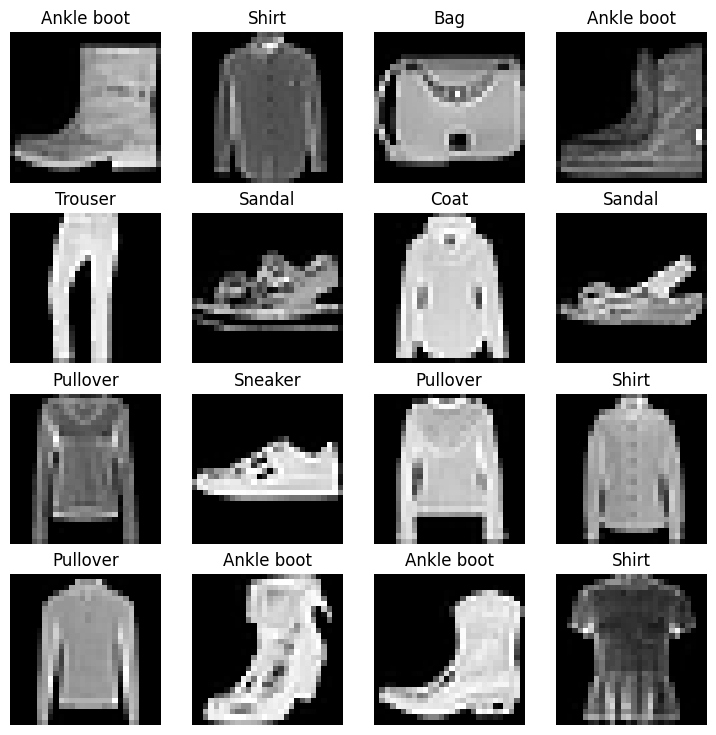

In [10]:
#   Plot more images
torch.manual_seed(42)
fig  = plt.figure(figsize=(9,9))
row , cols = 4 , 4
for i in range(1, row*cols+1):
  random_idx = torch.randint(0, len(train_data) , size=[1]).item()
  # print(random_idx)
  img , label = train_data[random_idx]
  fig.add_subplot(row , cols , i)
  plt.imshow(img.squeeze() , cmap="gray")
  plt.title(class_name[label])
  plt.axis(False)


Do you think these items of clothing could be modelled with pure linear lines ? or pure non-linearity?

## 2. Prepare Dataloder

Right Now , our data is in the form of PyTorch dataset

More Specifically , we want to turn our data into batches (or mini-batches)


Why would we do this ?

1. It is more computationally efficient ,as in , your computing hardware may not be able to look (store in memory ) at 60000 image in one hit . So we break it down to 32 images at a time (batch size of 32)
2. It gives our neural netmore more chances to update its gredients per epoch.

In [11]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparemeter
BATCH_SIZE = 32

# Turn dataset into iterabels (batches)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7af7613d5a10>,
 <torch.utils.data.dataloader.DataLoader at 0x7af7613e9b10>)

In [12]:
# Lets check out what we have created
print(f"DataLoader: {train_dataloader , test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of : {BATCH_SIZE}...")

print(f"Length of test dataloader: {len(test_dataloader)} batches of : {BATCH_SIZE}...")

DataLoader: (<torch.utils.data.dataloader.DataLoader object at 0x7af7613d5a10>, <torch.utils.data.dataloader.DataLoader object at 0x7af7613e9b10>)
Length of train dataloader: 1875 batches of : 32...
Length of test dataloader: 313 batches of : 32...


In [13]:
train_features_batch , train_label_batch = next(iter(train_dataloader))
train_features_batch.shape , train_label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

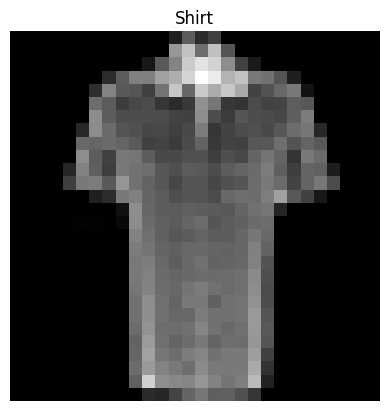

In [14]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0 , len(train_features_batch) , size=[1]).item()
img, label = train_features_batch[random_idx] , train_label_batch[random_idx]
plt.imshow(img.squeeze() , cmap="gray")
plt.title(class_name[label])
plt.axis(False)


### 3. Model 0 : Build a basline model

When starting to build a series of machine learning modelling experiment its best practie to start with a baseline model .

Abaseline model is a simple model you will try and improve upon with subsequent model/experiment

In other words : Start simply and add complexity When necessary.

In [15]:
# Creating a flatten layer

flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten the sample
output = flatten_model(x)

# Print out what happened
print(f"Shape before flattening : {x.shape}  - > [color_channel , height ,width]")
print(f"Shape aftert flattening: {output.shape} -> [color_channel , height * width]")

Shape before flattening : torch.Size([1, 28, 28])  - > [color_channel , height ,width]
Shape aftert flattening: torch.Size([1, 784]) -> [color_channel , height * width]


In [16]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape: int,
               ):

    super().__init__()
    self.layer_stack =  nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)


In [17]:
torch.manual_seed(42)

# Setup model with  input parameter
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,  # How many units in the hidden layers
    output_shape=len(class_name) # One for every class
)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [18]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

### 3.1 Setup loss , optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (Stochastic gradient descent )
* Evaluation metric - since we're working on a classification problem, let's use accuracy our evalution

In [19]:
import requests
import numpy as np

from pathlib import Path

# Download helper function from learn pytorch repo

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Download the helper_functions.py")
  requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py" , "wb") as f:
    f.write(requests.content)

Download the helper_functions.py


In [20]:
# Import the accuracy metrics from heplper function
from helper_functions import accuracy_fn

# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 # Creating a function to time our experiments

Machine learning is very experimental.

Two of the main things you'll often want to track are:

1. Model's performance
2. How fast it runs

In [21]:
from timeit import default_timer as timer
def print_train_time(start:float,
                     end:float,
                     device: torch.device = None):
  """Prints Difference between start and end time."""
  total_time = end- start
  print((f"Train time on {device}: {total_time:.3f} seconds"))
  return total_time

In [22]:
start_time = timer()
# Same code...
end_time = timer()
print_train_time(start=start_time , end=end_time , device='cpu')

Train time on cpu: 0.000 seconds


2.576199997861295e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs
2. Loop through training batches , perform training steps , calculate the train loss per batch
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print out what's happening
5. Time it all (for fun)

In [23]:
# import tqdm for progress bar
from tqdm.auto import tqdm

# Lets set the seed
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for fastest training time)
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")

    # Training
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    # Average train loss
    train_loss /= len(train_dataloader)

    # Testing loop
    test_loss, test_acc = 0.0, 0.0
    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(
                y_true=y_test,
                y_pred=test_pred.argmax(dim=1)
            )

    # Average test metrics
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    print(f"\nTrain Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}%")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device)
)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.5904 | Test Loss: 0.5095, Test Acc: 82.0387%
Epoch: 1
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4763 | Test Loss: 0.4799, Test Acc: 83.1969%
Epoch: 2
-----
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train Loss: 0.4550 | Test Loss: 0.4766, Test Acc: 83.4265%
Train time on cpu: 36.365 seconds


### 4. Make predictions and get model 0 results

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 5. Setup device agnostic-code (for using a GPU if there is one )


In [25]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Return a dictionary containing the result of the model predicting on the data_loader"""
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Move to device
            X, y = X.to(device), y.to(device)

            # Make prediction (INDENTED inside loop )
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1))

    # Scale loss and acc to find the average loss/ per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}

model_0 = model_0.to(device)

# Calculate model 0 results on test dataset
model_0_results = eval_model(model = model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device
                             )


model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663889868190873,
 'model_acc': 83.42651757188499}

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 6.  Model 1: Building a better model with non-linearity

We have learned about the power of non-linearity in the 02_Notebook

In [27]:
# Createa a model with non-linear and linear layers
import torch
from torch import nn
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape: int,
               ):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self , x : torch.Tensor):
    return self.layer_stack(x)


In [28]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_name)
                              ).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

##6.1 Lets create a loss and optimizer function for the model 1 and evaluation metrics too


In [29]:
from helper_functions import accuracy_fn

# Creating a loss function
loss_fn = nn.CrossEntropyLoss()   # measure how wrong our model is

#Creating optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),  # it tries to update our model's parameter to reduce the loss
                            lr=0.1)


### 6.2 Functionizing training and evaluation/test loss

Let's create a function for:

* Training loop = `train_step`
* Test loop = `test_step`

In [30]:
def train_step(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
  """Performs a training with model trying to learn on data_loader"""
  train_loss , train_acc = 0, 0
  model.train()
  #Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device) , y.to(device)

    # Forward pass (Outputs the raw logits from the model)
    y_pred = model(X)

    # Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss  ## accumulate the total trian loss from all the batches
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # logits to prediction labels
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Devide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss : {train_loss:.5f} | Train acc : {train_acc:.2f}%")




In [31]:
def test_step(model:torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn,
              device:torch.device = device):
   """Performs a testing loop step model going over on data_loader"""
   test_loss , test_acc = 0 , 0
   model.eval()

  #Turn on inference mode
   with torch.inference_mode():
    for X , y in data_loader:
      # Send the data to the target device
      X, y = X.to(device) , y.to(device)

      #forward pass
      test_pred = model(X)

      #Calculate the loss / acc
      loss = loss_fn(test_pred , y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss : {test_loss:.5f} | Test Acc : {test_acc:.2f}%")


In [32]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  train_step(model=model_1,
             data_loader = train_dataloader,
             loss_fn= loss_fn,
             optimizer= optimizer,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
            )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss : 1.09199 | Train acc : 61.34%
Test Loss : 0.95636 | Test Acc : 65.00%
Epoch: 1
-----
Train loss : 0.78101 | Train acc : 71.93%
Test Loss : 0.72227 | Test Acc : 73.91%
Epoch: 2
-----
Train loss : 0.67027 | Train acc : 75.94%
Test Loss : 0.68500 | Test Acc : 75.02%
Train time on cuda: 41.592 seconds


In [33]:
### Results of model 1
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850009789101232,
 'model_acc': 75.01996805111821}

### Model 2 : Building a Convolutional Neural Netwrok (CNN)

CNN's are also known ConvNets.

CNN's are know for their capabilities to find patterns in visula data.

To find out whats happening - https://poloclub.github.io/cnn-explainer/

The whole bunch of cnn layers compress together called block and the whole group of block compress together called Architecture

In [34]:
# Create a convolutional neural network

class FashionMNISTModelV2(nn.Module):
  """
  Model Architecture that replicates the TinyVGG
  model from cnn explainer website...
  """
  def __init__(self , input_shape : int , hidden_units:int, output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),  # Values we can set ourself in nn referes as hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1 : {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2 : {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier : {x.shape}")
    return x



In [35]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_name)).to(device)

In [36]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [37]:
# Pass the image through the model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

## 7.3 Setup a loss function and optimizer for model 2

In [38]:
# Creating a loss/eval/optimizer function
from helper_functions import accuracy_fn

loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

### 7.4  Training and testing loop using our train and test step function

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 4
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n-----")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                            end= train_time_end_model_2,
                                            device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch : 0
-----
Train loss : 1.03783 | Train acc : 62.34%
Test Loss : 0.62514 | Test Acc : 76.92%
Epoch : 1
-----
Train loss : 0.54926 | Train acc : 80.00%
Test Loss : 0.49809 | Test Acc : 81.56%
Epoch : 2
-----
Train loss : 0.45575 | Train acc : 83.53%
Test Loss : 0.44028 | Test Acc : 84.25%
Epoch : 3
-----
Train loss : 0.41331 | Train acc : 85.13%
Test Loss : 0.41359 | Test Acc : 85.49%
Train time on cuda: 64.161 seconds


In [40]:
# Get a model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.41358798594710927,
 'model_acc': 85.4932108626198}

In [41]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663889868190873,
 'model_acc': 83.42651757188499}

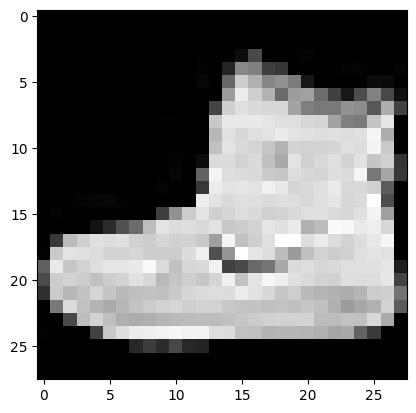

In [42]:
plt.imshow(image.squeeze() , cmap="gray")

### 7.1 Stepping through `nn.Conv2d`

In [76]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3 ,64 , 64))
test_image = image[0]
test_image = test_image.unsqueeze(0)

print(f"Image batch shape : {images.shape}")
print(f"Single image shape : {test_image.shape}")
# print(f"Test image:\n {test_image}")


Image batch shape : torch.Size([32, 3, 64, 64])
Single image shape : torch.Size([1, 28, 28])


In [44]:
test_image.shape

torch.Size([1, 28, 28])

In [45]:
# Create a single Conv2d layer
conv_layer = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=0)

# Pass the data through thr convolutional layer
conv_ouput = conv_layer(test_image)
conv_ouput

tensor([[[-0.1864, -0.1864, -0.1864,  ..., -0.1864, -0.1864, -0.1864],
         [-0.1864, -0.1864, -0.1864,  ..., -0.1853, -0.1848, -0.1867],
         [-0.1864, -0.1864, -0.1864,  ..., -0.1866, -0.1892, -0.1825],
         ...,
         [-0.2187, -0.3176, -0.4522,  ..., -0.4549, -0.4794, -0.4165],
         [-0.1878, -0.1864, -0.2159,  ..., -0.3869, -0.2891, -0.2250],
         [-0.1864, -0.1864, -0.1864,  ..., -0.1864, -0.1864, -0.1864]],

        [[-0.0844, -0.0844, -0.0844,  ..., -0.0844, -0.0844, -0.0844],
         [-0.0844, -0.0844, -0.0844,  ..., -0.0843, -0.0850, -0.0859],
         [-0.0844, -0.0844, -0.0844,  ..., -0.0903, -0.0886, -0.0857],
         ...,
         [-0.0680, -0.0404, -0.1693,  ..., -0.5585, -0.4362, -0.4336],
         [-0.0869, -0.0844, -0.0676,  ..., -0.2838, -0.2106, -0.1564],
         [-0.0844, -0.0844, -0.0844,  ..., -0.0844, -0.0844, -0.0844]],

        [[-0.1304, -0.1304, -0.1304,  ..., -0.1304, -0.1304, -0.1304],
         [-0.1304, -0.1304, -0.1304,  ..., -0

###7.2  Stepping through `nn.MaxPool2d()`


In [46]:
# Print out original image shape without unsqueeze dimension
print(f"Test image original shape : {test_image.shape}")
# print(f"Test image withoud unsqueeze dimension : {test_image.unsqueeze(dim=0)}")

# Createa sample nn.MaxPool2dlayer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# PASS Data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Sape after going through conv_layer(): {test_image_through_conv.shape}")

# pass data through maxpool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer and max_pool_layer() : {test_image_through_conv_and_max_pool.shape}")


Test image original shape : torch.Size([1, 28, 28])
Sape after going through conv_layer(): torch.Size([1, 10, 26, 26])
Shape after going through conv_layer and max_pool_layer() : torch.Size([1, 10, 13, 13])


In [47]:
torch.manual_seed(42)
# Create a random tesnror with a similar number of dimension to our images

random_tensor = torch.randn(size=(1, 1 , 2, 2))
print(f"\nRandom tensor : \n{random_tensor}")
print(f"Random tensor shape : {random_tensor.shape}")
# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass the random thensor through the max pool layer
max_pool_tesnor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor  : {max_pool_tesnor}")
print(f"Max pool tensor shape : {max_pool_tesnor.shape}")




Random tensor : 
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape : torch.Size([1, 1, 2, 2])

Max pool tensor  : tensor([[[[0.3367]]]])
Max pool tensor shape : torch.Size([1, 1, 1, 1])


### 8 Compare the model result and training time

In [48]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.413588,85.493211


In [49]:
## Add training time to results comparision
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]

compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,36.365477
1,FashionMNISTModelV1,0.685001,75.019968,41.591680
2,FashionMNISTModelV2,0.413588,85.493211,64.161231


Text(0, 0.5, 'model')

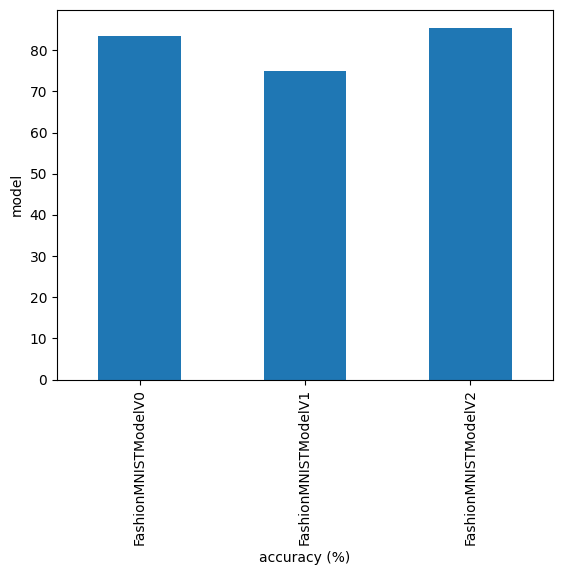

In [50]:
## Visualize oue model results
compare_results.set_index("model_name")["model_acc"].plot(kind="bar")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

### 9 Make and evaluate random prediction witht the best model

In [51]:
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device:torch.device=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forwar pass
      pred_logits = model(sample)

      # Get prediction probability (logits -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      #Get pred_prob off the GPU for further calculation
      pred_probs.append(pred_prob.cpu())


# Stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

In [52]:
import random
random.seed(42)
test_samples =[]
test_labels = []
for sample, label in random.sample(list(test_data) ,k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape



torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

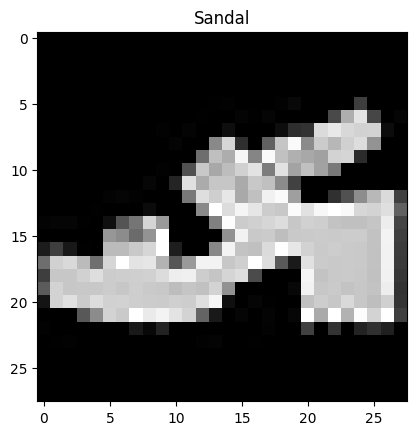

In [53]:
plt.imshow(test_samples[0].squeeze() , cmap="gray")
plt.title(class_name[test_labels[0]])

In [54]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two predictions probabilities
pred_probs[:2]

tensor([[5.2745e-08, 3.8888e-09, 1.2550e-07, 2.0959e-08, 1.2074e-09, 9.8481e-01,
         5.6034e-08, 2.6621e-05, 9.6764e-05, 1.5062e-02],
        [6.0161e-03, 8.9171e-01, 2.2692e-03, 8.2184e-02, 1.1452e-02, 4.3379e-05,
         5.5126e-03, 7.8907e-05, 7.2697e-04, 4.2715e-06]])

In [55]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 2, 3, 0, 4, 7, 1])

In [56]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

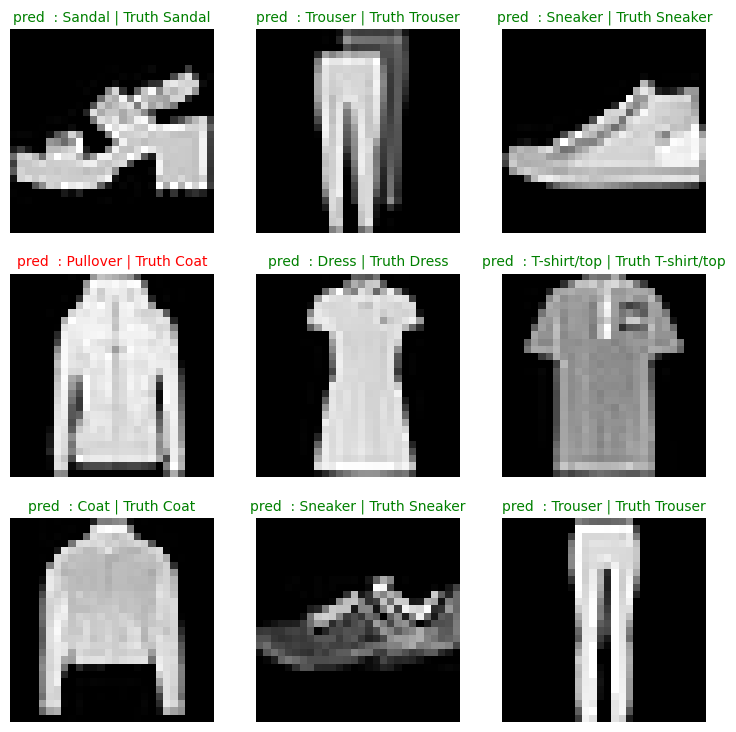

In [57]:
from math import fabs
# Plot the prediction
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i , sample in enumerate(test_samples):
  #Create subplot
  plt.subplot(nrows , ncols , i+1)

  #plot the target image
  plt.imshow(sample.squeeze() ,cmap="gray")

  # Find the prediction
  pred_label = class_name[pred_classes[i]]

  #Get the truth label
  truth_label = class_name[test_labels[i]]

  #Create a title for the plot
  title_text = f"pred  : {pred_label} | Truth {truth_label}"

  # Check for equality between pred and truth and chnage color of title text
  if pred_label == truth_label:
    plt.title(title_text , fontsize=10, c="g")
  else:
    plt.title(title_text , fontsize=10, c="r")

  plt.axis(False)

### 10. Making confusion matrix for further prediction evaluation

A confusion matrix is a fantastic way of evaluating your classification models visually.

1. Make prediction with our trained model on the dataset
2. Make a confusion matrix `torchmetric.ConfusionMatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [58]:
from tqdm.auto import tqdm


# Make prediction witht the trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader , desc = "Making predictions.."):
  #Send the data and targets to target device
    X , y = X.to(device) , y.to(device)
  # Do the forward pass
    y_logit = model_2(X)
  #Turn prediction from logits -> pred prob -> pred -> label
    y_pred = torch.softmax(y_logit.squeeze() , dim=0).argmax(dim=1)
  # Put the prediction on CPU  for evaluation
    y_preds.append(y_pred.cpu())


# Concatenate list of predictions into tensor

# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions..:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [61]:
## See if the required packages are installed and if not, install them...

try:
  import torchmetrics, mlxtend
  print(f"mlxtend version : {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1] >= 19 , "mlxtend version should be 0.19 or greater")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics , mlxtend
  print(f"mlxtend version : {mlxtend.__version__}")


mlxtend version : 0.23.4
mlxtend version : 0.23.4


In [62]:
mlxtend.__version__

'0.23.4'

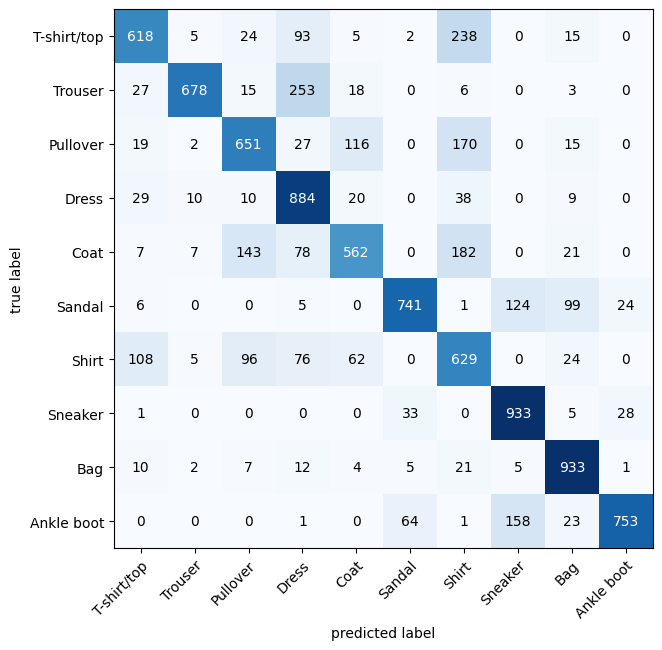

In [71]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2setup the confusion instance and compare predictions to targets
confmat =  ConfusionMatrix(task="multiclass", num_classes=(len(class_name)))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3 plot the confusion matrix
fig , ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_name,
    figsize=(10,7)
)

### 10.1 Let's Save and load our best model

In [73]:
# Saving our best model
from pathlib import Path

# Create a model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to : models/03_pytorch_computer_vision_model_2.pth


In [74]:
# Create a new instance to load the model
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_name))

# Load in the save state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to target device
loaded_model_2.to(device)


FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [75]:
# Evaluate the model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.41358798594710927,
 'model_acc': 85.4932108626198}